### Inference with tflite model

In [ ]:
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

### Import packages

In [1]:
from absl import app, flags, logging
from absl.flags import FLAGS
import tensorflow as tf
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import os
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder
import pathlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
tf.__version__

### Load tflite model

In [2]:
interpreter = tf.lite.Interpreter(model_path="{tflite model}")
interpreter.allocate_tensors()
logging.info('tflite model loaded')
interpreter

### Load pipeline config file

In [3]:
pipeline_config = '{pipeline.config}'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
num_classes = 1
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)
detection_model

In [4]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### Image preprocess

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores

### Input image detection

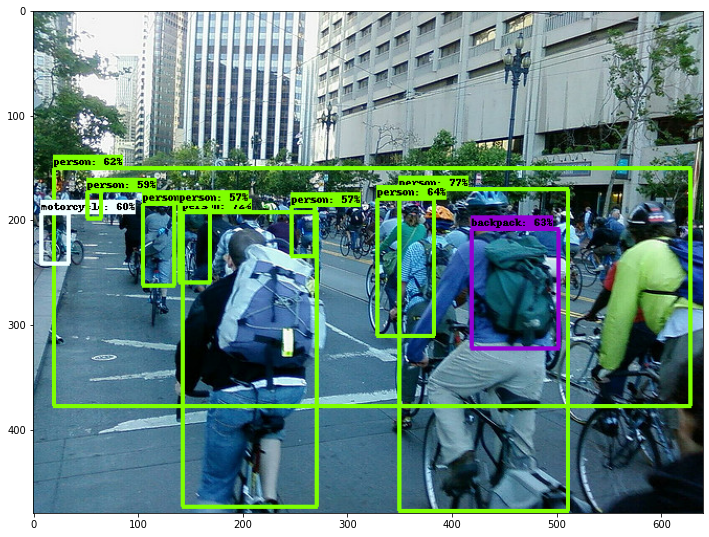

In [6]:
image_path = "000000179672.jpg"
image_np = load_image_into_numpy_array(image_path)
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
boxes, classes, scores = detect(interpreter, input_tensor)
label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      boxes[0],
      (classes[0].astype(np.uint32) + label_id_offset).astype(int),
      scores[0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()